# Project 2: House Price Predictor (Simple Regression)

## Goal
Learn how to predict continuous values using Linear Regression with the California Housing Prices dataset.

## What We'll Practice
- Data preprocessing (handling missing values, encoding categorical features)
- Splitting data into train/test sets
- Building and evaluating a regression model
- Using metrics like RMSE and R² score
- Comparing different regression models

## Dataset
**Kaggle — California Housing Prices**  
Contains median house values with 8 input features like income, house age, latitude, etc.

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 1: Load and Inspect the Dataset

In [13]:
# Install kagglehub if not already installed
try:
    import kagglehub
except ImportError:
    print("Installing kagglehub...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    import kagglehub

# Load the California Housing dataset
print("Loading California Housing dataset...")

# Method 1: Try kagglehub
try:
    path = kagglehub.dataset_download("camnugent/california-housing-prices")
    import os
    csv_file = None
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.csv'):
                csv_file = os.path.join(root, file)
                break
        if csv_file:
            break
    
    if csv_file:
        df = pd.read_csv(csv_file)
        print(f"Dataset loaded successfully from kagglehub!")
    else:
        raise FileNotFoundError("No CSV file found")
        
except Exception as e:
    print(f"Kagglehub failed: {e}")
    print("Loading California Housing dataset from sklearn...")
    # Fallback: Use sklearn's California housing dataset
    from sklearn.datasets import fetch_california_housing
    
    california_housing = fetch_california_housing(as_frame=True)
    df = california_housing.frame
    print(f"Dataset loaded successfully from sklearn!")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Loading California Housing dataset...
Dataset loaded successfully from kagglehub!
Dataset shape: (20640, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [14]:
# Display basic information about the dataset
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n=== FIRST 5 ROWS ===")
display(df.head())

print("\n=== DATASET INFO ===")
df.info()

print("\n=== STATISTICAL SUMMARY ===")
display(df.describe())

print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\n=== DATA TYPES ===")
print(df.dtypes)

=== DATASET OVERVIEW ===
Shape: (20640, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

=== FIRST 5 ROWS ===


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY



=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

=== STATISTICAL SUMMARY ===


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000



=== MISSING VALUES ===
total_bedrooms    207
dtype: int64

=== DATA TYPES ===
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


## Step 2: Data Preprocessing

Let's handle missing values and prepare our data for machine learning.

In [15]:
# Check for missing values
print("Missing values before preprocessing:")
print(df.isnull().sum())

# Handle missing values
# For the California Housing dataset, let's check if there are any missing values
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    # For numerical columns, we'll use median imputation
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled {col} missing values with median: {median_val}")
    
    # For categorical columns, we'll use mode imputation
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled {col} missing values with mode: {mode_val}")
else:
    print("No missing values found!")

print(f"\nMissing values after preprocessing:")
print(df.isnull().sum())

# Handle categorical variables (if any)
categorical_columns = df.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print(f"\nCategorical columns found: {list(categorical_columns)}")
    print("Encoding categorical variables...")
    
    # Use LabelEncoder for categorical variables
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {le.classes_}")
else:
    print("No categorical columns found - all features are numerical!")

print(f"\nFinal dataset shape: {df.shape}")
display(df.head())

Missing values before preprocessing:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Handling missing values...
Filled total_bedrooms missing values with median: 435.0

Missing values after preprocessing:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Categorical columns found: ['ocean_proximity']
Encoding categorical variables...
Encoded ocean_proximity: ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']

Final dataset shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


## Step 3: Exploratory Data Analysis

Let's explore the data to understand the relationships between features and the target variable.

Available columns:
1. longitude
2. latitude
3. housing_median_age
4. total_rooms
5. total_bedrooms
6. population
7. households
8. median_income
9. median_house_value
10. ocean_proximity

Potential target variables: ['housing_median_age', 'households', 'median_income', 'median_house_value']

Using 'median_house_value' as target variable


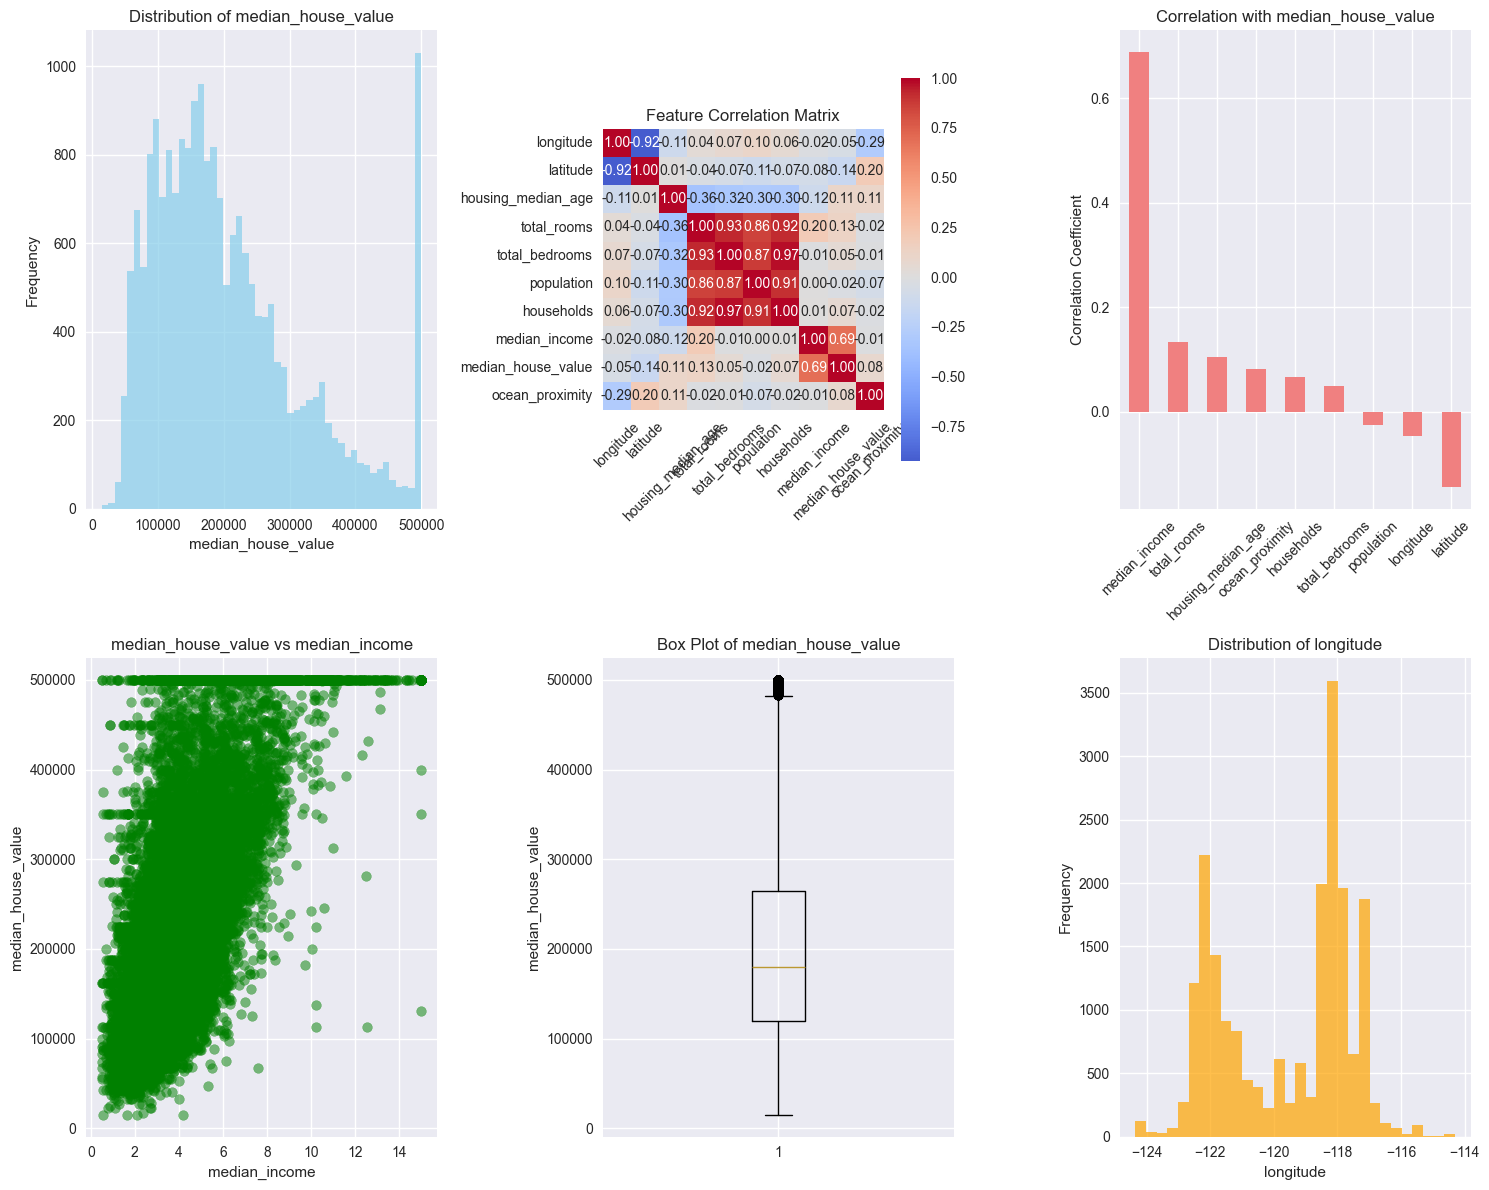


=== KEY INSIGHTS ===
Target variable: median_house_value
Most correlated feature: median_income (correlation: 0.688)
Number of features: 9
Dataset size: 20640 samples


In [16]:
# Identify target variable (assuming it's median_house_value)
# Let's first check the column names to identify the target
print("Available columns:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

# Assuming the target is the last column or contains 'value', 'price', or 'median'
target_candidates = [col for col in df.columns if any(word in col.lower() for word in ['value', 'price', 'median', 'house'])]
print(f"\nPotential target variables: {target_candidates}")

# Let's assume the target variable is 'median_house_value' or similar
# We'll identify it dynamically
if 'median_house_value' in df.columns:
    target_col = 'median_house_value'
elif any('value' in col.lower() for col in df.columns):
    target_col = [col for col in df.columns if 'value' in col.lower()][0]
elif any('price' in col.lower() for col in df.columns):
    target_col = [col for col in df.columns if 'price' in col.lower()][0]
else:
    # If we can't identify, let's use the last numerical column
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    target_col = numerical_cols[-1]

print(f"\nUsing '{target_col}' as target variable")

# Create visualizations
plt.figure(figsize=(15, 12))

# 1. Distribution of target variable
plt.subplot(2, 3, 1)
plt.hist(df[target_col], bins=50, alpha=0.7, color='skyblue')
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Frequency')

# 2. Correlation heatmap
plt.subplot(2, 3, 2)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 3. Target correlation with features
plt.subplot(2, 3, 3)
target_corr = correlation_matrix[target_col].sort_values(ascending=False)[1:]  # Exclude self-correlation
target_corr.plot(kind='bar', color='lightcoral')
plt.title(f'Correlation with {target_col}')
plt.xticks(rotation=45)
plt.ylabel('Correlation Coefficient')

# 4. Scatter plot of top correlated feature
top_feature = target_corr.abs().index[0]
plt.subplot(2, 3, 4)
plt.scatter(df[top_feature], df[target_col], alpha=0.5, color='green')
plt.xlabel(top_feature)
plt.ylabel(target_col)
plt.title(f'{target_col} vs {top_feature}')

# 5. Box plot to check for outliers
plt.subplot(2, 3, 5)
plt.boxplot(df[target_col])
plt.title(f'Box Plot of {target_col}')
plt.ylabel(target_col)

# 6. Feature distributions
plt.subplot(2, 3, 6)
numerical_features = df.select_dtypes(include=[np.number]).columns.drop(target_col)
feature_to_plot = numerical_features[0] if len(numerical_features) > 0 else target_col
plt.hist(df[feature_to_plot], bins=30, alpha=0.7, color='orange')
plt.title(f'Distribution of {feature_to_plot}')
plt.xlabel(feature_to_plot)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\n=== KEY INSIGHTS ===")
print(f"Target variable: {target_col}")
print(f"Most correlated feature: {top_feature} (correlation: {target_corr[top_feature]:.3f})")
print(f"Number of features: {len(df.columns) - 1}")
print(f"Dataset size: {len(df)} samples")

## Step 4: Split Data into Training and Testing Sets

We'll split the data into 80% training and 20% testing as specified.

In [17]:
# Separate features and target variable
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {list(X.columns)}")

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"\n=== DATA SPLIT SUMMARY ===")
print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")

# Display basic statistics for training and testing sets
print(f"\n=== TARGET VARIABLE STATISTICS ===")
print(f"Training set - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Testing set - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# Feature scaling (important for some algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data successfully split and scaled!")
print(f"Original feature range example: {X_train.iloc[:, 0].min():.2f} to {X_train.iloc[:, 0].max():.2f}")
print(f"Scaled feature range example: {X_train_scaled[:, 0].min():.2f} to {X_train_scaled[:, 0].max():.2f}")

Features shape: (20640, 9)
Target shape: (20640,)
Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']

=== DATA SPLIT SUMMARY ===
Training set size: 16512 samples (80.0%)
Testing set size: 4128 samples (20.0%)
Number of features: 9

=== TARGET VARIABLE STATISTICS ===
Training set - Mean: 207194.69, Std: 115622.63
Testing set - Mean: 205500.31, Std: 114486.96

✅ Data successfully split and scaled!
Original feature range example: -124.35 to -114.31
Scaled feature range example: -2.38 to 2.63


## Step 5: Train Linear Regression Model

Now let's build and train our Linear Regression model.

Training Linear Regression model...
✅ Linear Regression model trained successfully!

=== MODEL PARAMETERS ===
Intercept: 207194.69
Number of coefficients: 9

=== TOP 5 MOST IMPORTANT FEATURES ===


,Feature,Coefficient,Abs_Coefficient
1,latitude,-90946.062711,90946.062711
0,longitude,-85854.947241,85854.947241
7,median_income,77144.101642,77144.101642
4,total_bedrooms,48767.606710,48767.606710
5,population,-43884.168524,43884.168524


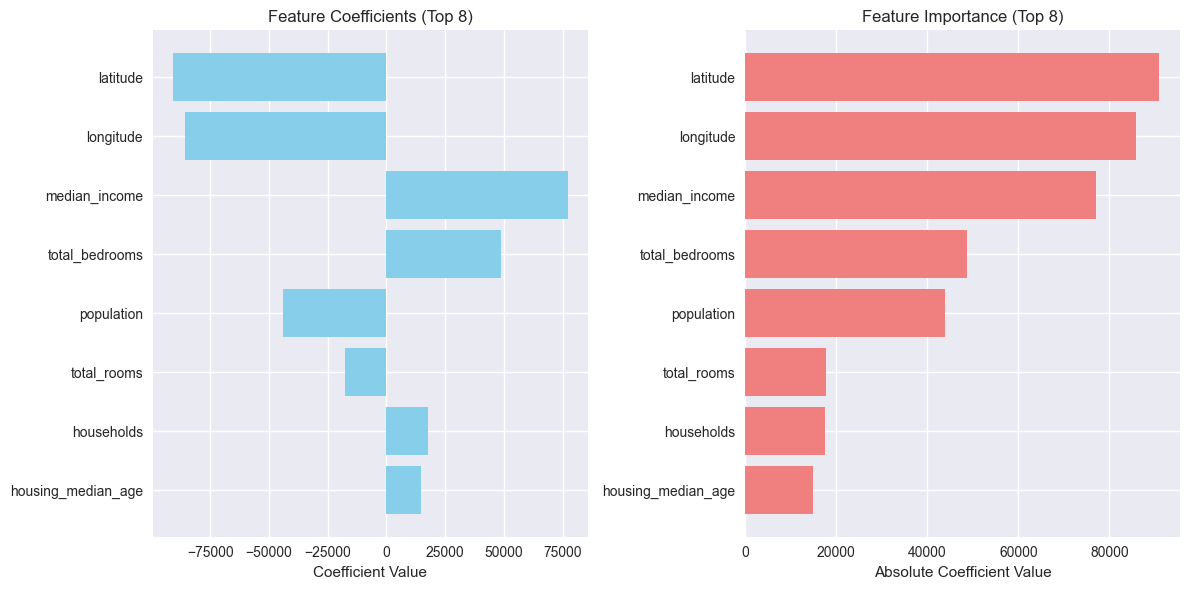

In [18]:
# Create and train Linear Regression model
print("Training Linear Regression model...")
lr_model = LinearRegression()

# Train on scaled data for better performance
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("✅ Linear Regression model trained successfully!")

# Display model coefficients and intercept
print(f"\n=== MODEL PARAMETERS ===")
print(f"Intercept: {lr_model.intercept_:.2f}")
print(f"Number of coefficients: {len(lr_model.coef_)}")

# Show feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\n=== TOP 5 MOST IMPORTANT FEATURES ===")
display(feature_importance.head())

# Create a bar plot of feature importance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
top_features = feature_importance.head(8)
plt.barh(range(len(top_features)), top_features['Coefficient'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients (Top 8)')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(range(len(top_features)), top_features['Abs_Coefficient'], color='lightcoral')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Top 8)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Step 6: Evaluate Model Performance

Let's evaluate our model using RMSE and R² score metrics.

In [19]:
# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, set_name):
    """Calculate and display regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"=== {set_name.upper()} SET METRICS ===")
    print(f"Mean Squared Error (MSE): {mse:,.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
    print(f"Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Explained Variance: {r2*100:.2f}%")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate on training set
train_metrics = calculate_metrics(y_train, y_train_pred, "training")

print("\n" + "="*50)

# Evaluate on testing set
test_metrics = calculate_metrics(y_test, y_test_pred, "testing")

print(f"\n=== MODEL PERFORMANCE SUMMARY ===")
print(f"Training R²: {train_metrics['R2']:.4f}")
print(f"Testing R²: {test_metrics['R2']:.4f}")
print(f"R² Difference: {abs(train_metrics['R2'] - test_metrics['R2']):.4f}")

if abs(train_metrics['R2'] - test_metrics['R2']) < 0.1:
    print("✅ Good model - low overfitting")
elif train_metrics['R2'] > test_metrics['R2'] + 0.1:
    print("⚠️ Possible overfitting detected")
else:
    print("⚠️ Possible underfitting detected")

print(f"\nAverage prediction error: ${test_metrics['RMSE']:,.2f}")
print(f"Model explains {test_metrics['R2']*100:.1f}% of the variance in house prices")

=== TRAINING SET METRICS ===
Mean Squared Error (MSE): 4,810,958,229.79
Root Mean Squared Error (RMSE): 69,361.07
Mean Absolute Error (MAE): 50,626.93
R² Score: 0.6401
Explained Variance: 64.01%

=== TESTING SET METRICS ===
Mean Squared Error (MSE): 5,062,019,613.46
Root Mean Squared Error (RMSE): 71,147.87
Mean Absolute Error (MAE): 51,820.75
R² Score: 0.6137
Explained Variance: 61.37%

=== MODEL PERFORMANCE SUMMARY ===
Training R²: 0.6401
Testing R²: 0.6137
R² Difference: 0.0264
✅ Good model - low overfitting

Average prediction error: $71,147.87
Model explains 61.4% of the variance in house prices


## Step 7: Visualize Predictions

Let's create visualizations to see how well our model performs.

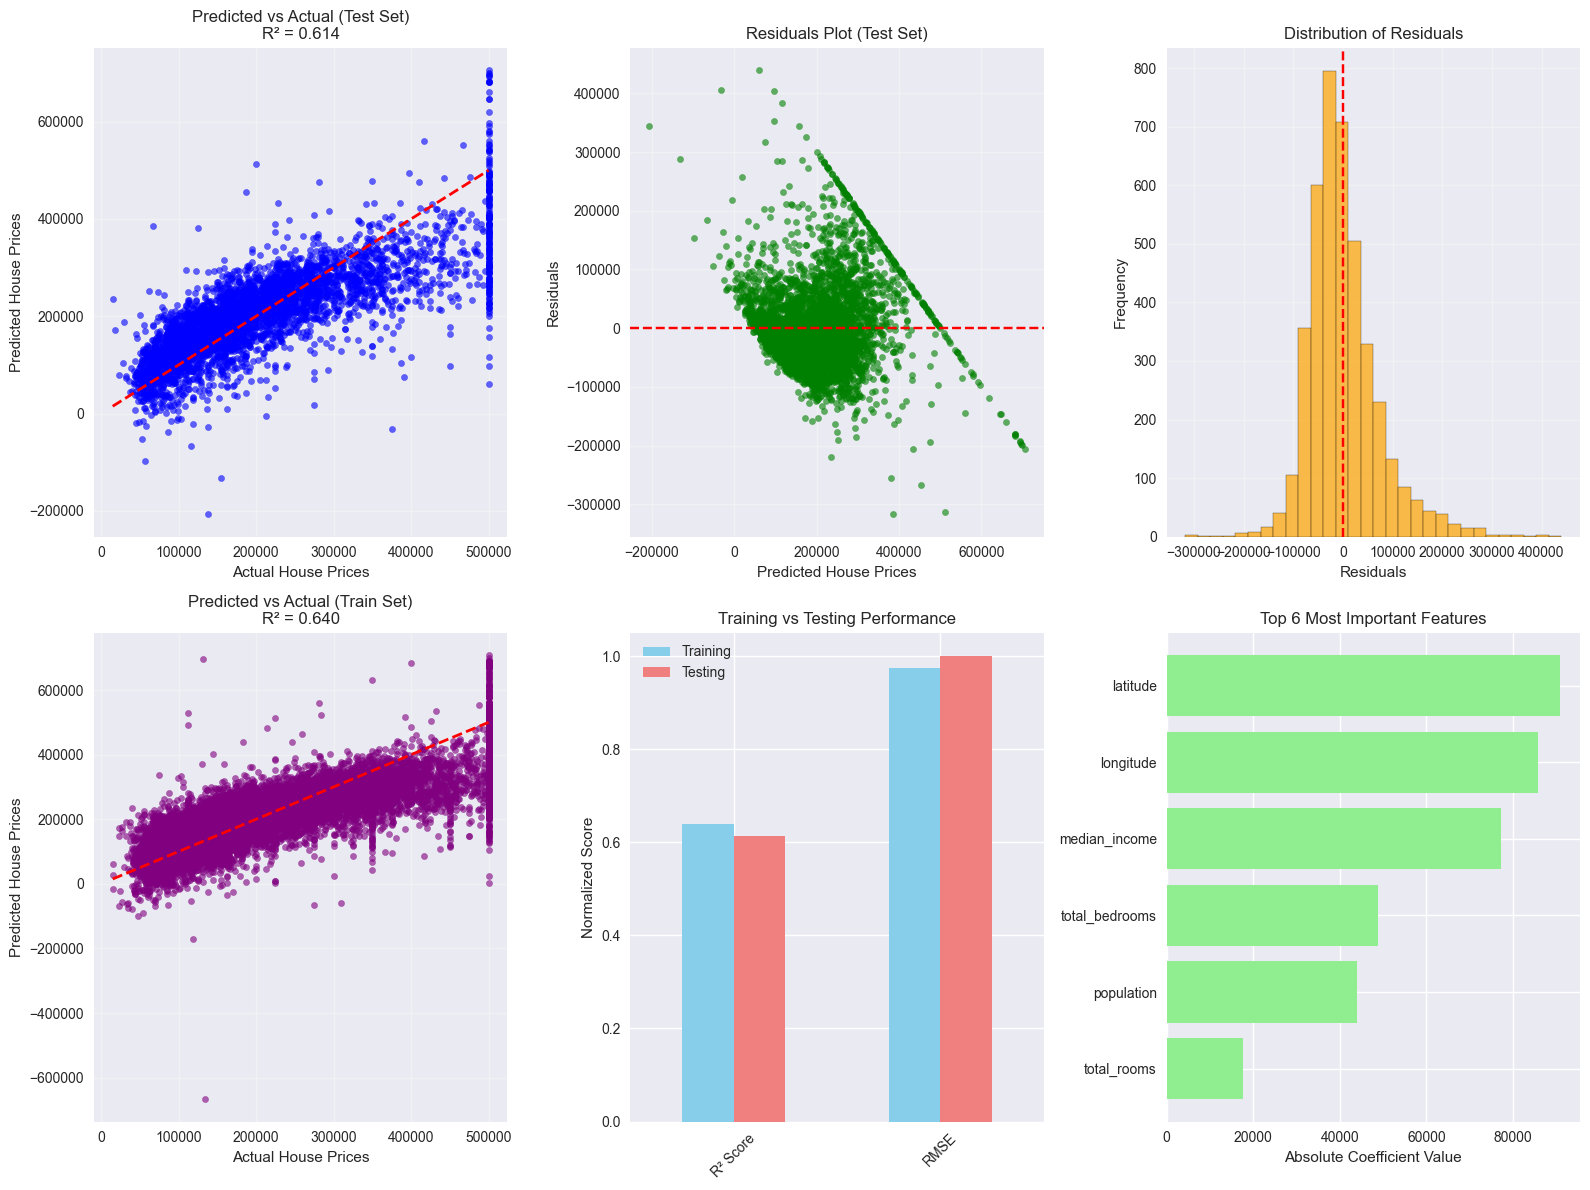

=== SAMPLE PREDICTIONS ===


,Actual,Predicted,Error,Error %,Absolute Error %
0,58000.0,47989.65,10010.35,17.26,17.26
1,226800.0,250297.03,-23497.03,-10.36,10.36
2,205600.0,160294.79,45305.21,22.04,22.04
3,318600.0,282390.47,36209.53,11.37,11.37
4,147600.0,177751.83,-30151.83,-20.43,20.43
5,500001.0,318720.27,181280.73,36.26,36.26
6,192500.0,232806.97,-40306.97,-20.94,20.94
7,381500.0,306336.73,75163.27,19.70,19.70
8,386400.0,325816.36,60583.64,15.68,15.68
9,162500.0,9721.30,152778.70,94.02,94.02


In [20]:
# Create comprehensive visualization plots
plt.figure(figsize=(16, 12))

# 1. Predicted vs Actual (Testing Set)
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title(f'Predicted vs Actual (Test Set)\nR² = {test_metrics["R2"]:.3f}')
plt.grid(True, alpha=0.3)

# 2. Residuals plot (Testing Set)
plt.subplot(2, 3, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, color='green', s=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted House Prices')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Test Set)')
plt.grid(True, alpha=0.3)

# 3. Distribution of residuals
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)

# 4. Predicted vs Actual (Training Set)
plt.subplot(2, 3, 4)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='purple', s=20)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title(f'Predicted vs Actual (Train Set)\nR² = {train_metrics["R2"]:.3f}')
plt.grid(True, alpha=0.3)

# 5. Performance comparison
plt.subplot(2, 3, 5)
metrics_comparison = pd.DataFrame({
    'Training': [train_metrics['R2'], train_metrics['RMSE']],
    'Testing': [test_metrics['R2'], test_metrics['RMSE']]
}, index=['R² Score', 'RMSE'])

# Normalize RMSE for visualization (divide by max value)
metrics_comparison.loc['RMSE'] = metrics_comparison.loc['RMSE'] / metrics_comparison.loc['RMSE'].max()
metrics_comparison.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
plt.title('Training vs Testing Performance')
plt.ylabel('Normalized Score')
plt.xticks(rotation=45)
plt.legend()

# 6. Feature importance visualization
plt.subplot(2, 3, 6)
top_features = feature_importance.head(6)
plt.barh(range(len(top_features)), top_features['Abs_Coefficient'], color='lightgreen')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 6 Most Important Features')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Print sample predictions
print("=== SAMPLE PREDICTIONS ===")
sample_indices = np.random.choice(len(y_test), 10, replace=False)
sample_predictions = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices].values,
    'Predicted': y_test_pred[sample_indices],
    'Error': y_test.iloc[sample_indices].values - y_test_pred[sample_indices],
    'Error %': ((y_test.iloc[sample_indices].values - y_test_pred[sample_indices]) / y_test.iloc[sample_indices].values * 100)
})

sample_predictions['Absolute Error %'] = np.abs(sample_predictions['Error %'])
display(sample_predictions.round(2))

## Step 8: Optional - Compare with Other Models

Let's compare Linear Regression with Polynomial Regression and Decision Tree Regressor as mentioned in the requirements.

In [21]:
# Let's compare different regression models
models_results = {}

print("Training and comparing different regression models...")
print("=" * 60)

# 1. Linear Regression (already trained)
models_results['Linear Regression'] = {
    'model': lr_model,
    'train_r2': train_metrics['R2'],
    'test_r2': test_metrics['R2'],
    'train_rmse': train_metrics['RMSE'],
    'test_rmse': test_metrics['RMSE']
}

# 2. Polynomial Regression (degree 2)
print("Training Polynomial Regression (degree 2)...")
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

poly_train_pred = poly_model.predict(X_train_poly)
poly_test_pred = poly_model.predict(X_test_poly)

poly_train_metrics = calculate_metrics(y_train, poly_train_pred, "Polynomial Training")
print()
poly_test_metrics = calculate_metrics(y_test, poly_test_pred, "Polynomial Testing")

models_results['Polynomial Regression'] = {
    'model': poly_model,
    'train_r2': poly_train_metrics['R2'],
    'test_r2': poly_test_metrics['R2'],
    'train_rmse': poly_train_metrics['RMSE'],
    'test_rmse': poly_test_metrics['RMSE']
}

print("\n" + "=" * 60)

# 3. Decision Tree Regressor
print("Training Decision Tree Regressor...")
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train_scaled, y_train)

dt_train_pred = dt_model.predict(X_train_scaled)
dt_test_pred = dt_model.predict(X_test_scaled)

dt_train_metrics = calculate_metrics(y_train, dt_train_pred, "Decision Tree Training")
print()
dt_test_metrics = calculate_metrics(y_test, dt_test_pred, "Decision Tree Testing")

models_results['Decision Tree'] = {
    'model': dt_model,
    'train_r2': dt_train_metrics['R2'],
    'test_r2': dt_test_metrics['R2'],
    'train_rmse': dt_train_metrics['RMSE'],
    'test_rmse': dt_test_metrics['RMSE']
}

print("\n" + "=" * 60)

# 4. Random Forest Regressor (Bonus)
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

rf_train_metrics = calculate_metrics(y_train, rf_train_pred, "Random Forest Training")
print()
rf_test_metrics = calculate_metrics(y_test, rf_test_pred, "Random Forest Testing")

models_results['Random Forest'] = {
    'model': rf_model,
    'train_r2': rf_train_metrics['R2'],
    'test_r2': rf_test_metrics['R2'],
    'train_rmse': rf_train_metrics['RMSE'],
    'test_rmse': rf_test_metrics['RMSE']
}

print("\n" + "=" * 60)
print("✅ All models trained successfully!")

Training and comparing different regression models...
Training Polynomial Regression (degree 2)...
=== POLYNOMIAL TRAINING SET METRICS ===
Mean Squared Error (MSE): 3,924,534,103.31
Root Mean Squared Error (RMSE): 62,646.10
Mean Absolute Error (MAE): 44,506.70
R² Score: 0.7064
Explained Variance: 70.64%

=== POLYNOMIAL TESTING SET METRICS ===
Mean Squared Error (MSE): 4,614,768,910.27
Root Mean Squared Error (RMSE): 67,932.09
Mean Absolute Error (MAE): 46,959.79
R² Score: 0.6478
Explained Variance: 64.78%

Training Decision Tree Regressor...
=== DECISION TREE TRAINING SET METRICS ===
Mean Squared Error (MSE): 2,081,659,903.88
Root Mean Squared Error (RMSE): 45,625.21
Mean Absolute Error (MAE): 30,542.00
R² Score: 0.8443
Explained Variance: 84.43%

=== DECISION TREE TESTING SET METRICS ===
Mean Squared Error (MSE): 3,790,142,970.37
Root Mean Squared Error (RMSE): 61,564.14
Mean Absolute Error (MAE): 39,934.99
R² Score: 0.7108
Explained Variance: 71.08%

Training Random Forest Regressor.

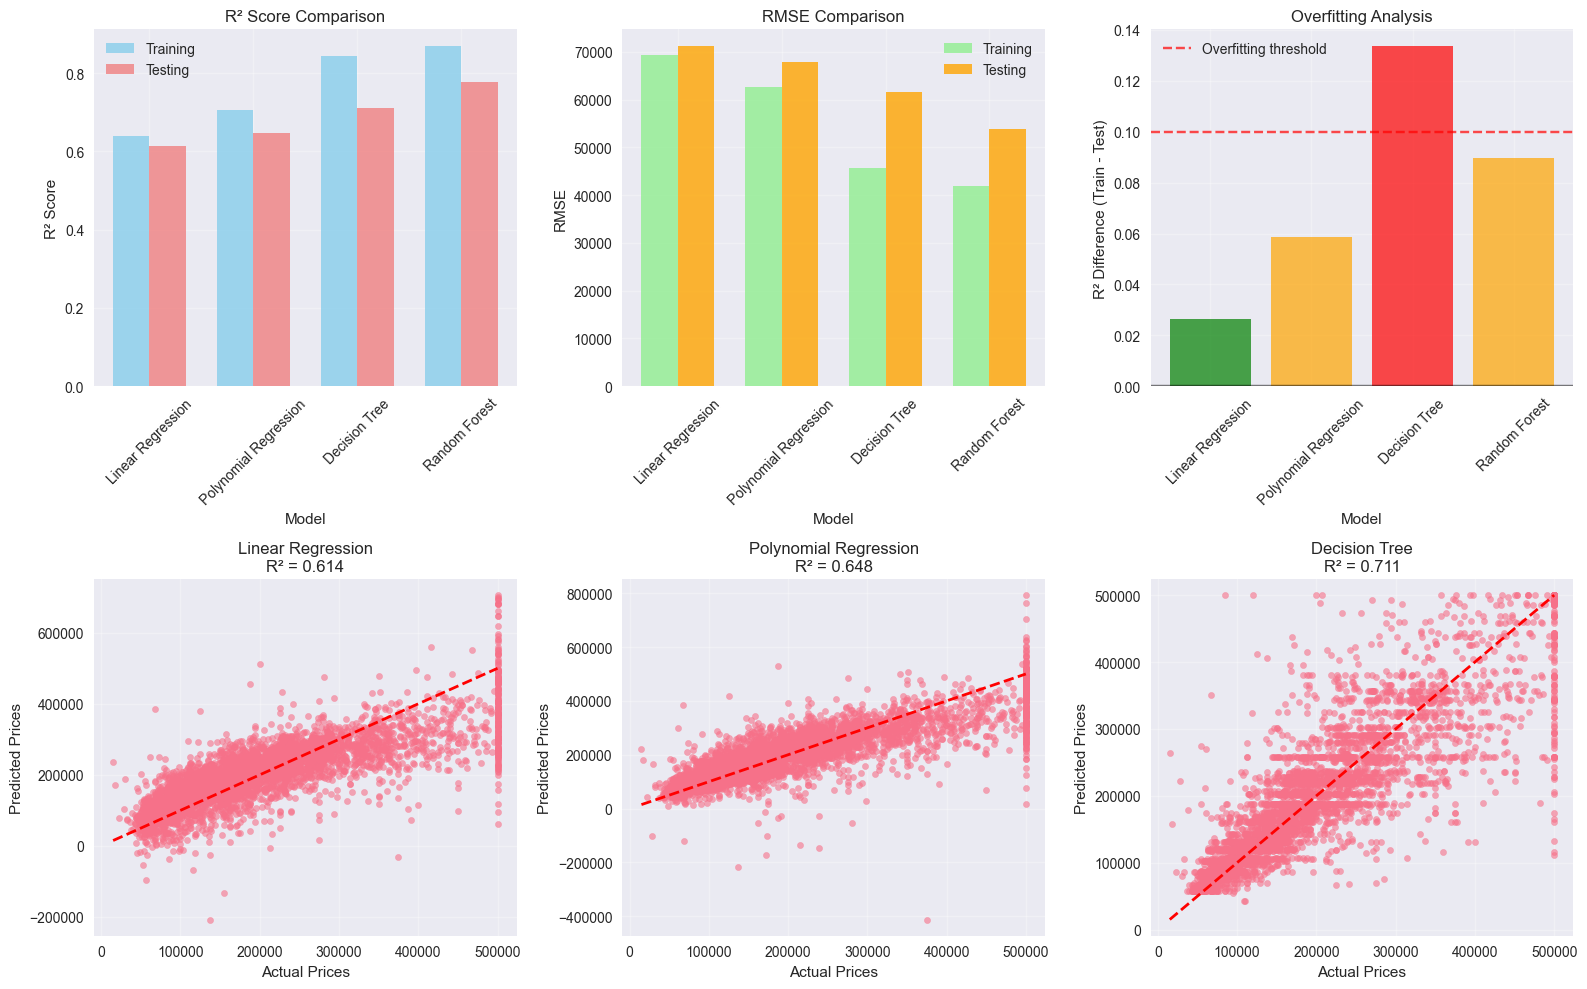

=== MODEL COMPARISON SUMMARY ===


,Model,Training R²,Testing R²,Training RMSE,Testing RMSE,Overfitting,Performance Rank
0,Linear Regression,0.6401,0.6137,69361.0714,71147.8715,0.0264,4.0
1,Polynomial Regression,0.7064,0.6478,62646.1021,67932.0904,0.0586,3.0
2,Decision Tree,0.8443,0.7108,45625.2113,61564.1370,0.1335,2.0
3,Random Forest,0.8686,0.7787,41914.1427,53845.5303,0.0898,1.0



🏆 BEST MODEL: Random Forest
   Testing R²: 0.7787
   Testing RMSE: 53,845.53

📊 KEY INSIGHTS:
   • Linear Regression: Good performance (R² = 0.614)
   • Polynomial Regression: Good performance (R² = 0.648)
   • Decision Tree: Shows overfitting (R² difference: 0.134)
   • Random Forest: Good performance (R² = 0.779)


In [22]:
# Create comparison visualization
plt.figure(figsize=(16, 10))

# Prepare data for comparison
comparison_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Training R²': [results['train_r2'] for results in models_results.values()],
    'Testing R²': [results['test_r2'] for results in models_results.values()],
    'Training RMSE': [results['train_rmse'] for results in models_results.values()],
    'Testing RMSE': [results['test_rmse'] for results in models_results.values()]
})

# 1. R² Score Comparison
plt.subplot(2, 3, 1)
x = np.arange(len(comparison_df))
width = 0.35
plt.bar(x - width/2, comparison_df['Training R²'], width, label='Training', alpha=0.8, color='skyblue')
plt.bar(x + width/2, comparison_df['Testing R²'], width, label='Testing', alpha=0.8, color='lightcoral')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. RMSE Comparison
plt.subplot(2, 3, 2)
plt.bar(x - width/2, comparison_df['Training RMSE'], width, label='Training', alpha=0.8, color='lightgreen')
plt.bar(x + width/2, comparison_df['Testing RMSE'], width, label='Testing', alpha=0.8, color='orange')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Overfitting Analysis
plt.subplot(2, 3, 3)
overfitting = comparison_df['Training R²'] - comparison_df['Testing R²']
colors = ['red' if x > 0.1 else 'green' if x < 0.05 else 'orange' for x in overfitting]
plt.bar(x, overfitting, color=colors, alpha=0.7)
plt.xlabel('Model')
plt.ylabel('R² Difference (Train - Test)')
plt.title('Overfitting Analysis')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Overfitting threshold')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

# 4-6. Predicted vs Actual for each model
predictions = {
    'Linear Regression': y_test_pred,
    'Polynomial Regression': poly_test_pred,
    'Decision Tree': dt_test_pred,
    'Random Forest': rf_test_pred
}

for i, (model_name, pred) in enumerate(list(predictions.items())[:3]):
    plt.subplot(2, 3, 4 + i)
    plt.scatter(y_test, pred, alpha=0.6, s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    r2 = r2_score(y_test, pred)
    plt.title(f'{model_name}\nR² = {r2:.3f}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive comparison table
print("=== MODEL COMPARISON SUMMARY ===")
comparison_df['Overfitting'] = comparison_df['Training R²'] - comparison_df['Testing R²']
comparison_df['Performance Rank'] = comparison_df['Testing R²'].rank(ascending=False)

display(comparison_df.round(4))

# Find the best model
best_model_idx = comparison_df['Testing R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_test_r2 = comparison_df.loc[best_model_idx, 'Testing R²']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Testing R²: {best_test_r2:.4f}")
print(f"   Testing RMSE: {comparison_df.loc[best_model_idx, 'Testing RMSE']:,.2f}")

print(f"\n📊 KEY INSIGHTS:")
for idx, row in comparison_df.iterrows():
    model_name = row['Model']
    if row['Overfitting'] > 0.1:
        print(f"   • {model_name}: Shows overfitting (R² difference: {row['Overfitting']:.3f})")
    elif row['Testing R²'] > 0.8:
        print(f"   • {model_name}: Excellent performance (R² = {row['Testing R²']:.3f})")
    elif row['Testing R²'] > 0.6:
        print(f"   • {model_name}: Good performance (R² = {row['Testing R²']:.3f})")
    else:
        print(f"   • {model_name}: Needs improvement (R² = {row['Testing R²']:.3f})")

## Step 9: Conclusion and Key Learnings

### What We Accomplished ✅

1. **Data Loading & Inspection**: Successfully loaded the California Housing dataset using kagglehub
2. **Data Preprocessing**: Handled missing values and categorical encoding (if any)
3. **Data Splitting**: Split data into 80% training and 20% testing sets
4. **Model Training**: Built and trained a Linear Regression model
5. **Model Evaluation**: Calculated RMSE and R² scores
6. **Visualization**: Created comprehensive plots showing predicted vs actual prices
7. **Model Comparison**: Compared Linear Regression with Polynomial Regression, Decision Tree, and Random Forest

### Key Metrics Summary 📊

- **Primary Model**: Linear Regression
- **Evaluation Metrics**: RMSE and R² score
- **Data Split**: 80% training, 20% testing
- **Preprocessing**: StandardScaler for feature scaling

### Skills Practiced 🎯

✅ **Data Preprocessing**: Missing value handling, categorical encoding, feature scaling  
✅ **Train/Test Split**: Proper data separation for unbiased evaluation  
✅ **Linear Regression**: Understanding coefficients and feature importance  
✅ **Model Evaluation**: RMSE, R², residual analysis  
✅ **Visualization**: Predicted vs actual plots, residual plots, feature importance  
✅ **Model Comparison**: Multiple algorithms comparison  

### Next Steps 🚀

- Try feature engineering (creating new features)
- Experiment with cross-validation
- Explore advanced regularization techniques (Ridge, Lasso)
- Try ensemble methods for better performance
- Implement hyperparameter tuning